## Imports

In [4]:
from utils import *
from scipy.stats import randint, uniform
import pandas as pd
from itertools import product
import numpy as np
import matplotlib.pyplot as plt
import ast
import seaborn as sns
import spacy
import contractions
import re
import emoji
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler,  MultiLabelBinarizer
from sklearn.metrics import silhouette_score, make_scorer, accuracy_score, f1_score, classification_report, confusion_matrix, precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold, KFold, cross_val_predict
from sklearn.multioutput import MultiOutputClassifier
from sklearn.utils import resample
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import zscore

nlp = spacy.load("en_core_web_sm")
rs = 42

# Description

- Classification : sci vs not sci
- Equilibrage : <span style="color:red">environ -250 not sci et +100 sci : équilibrage à 500 pour 500</span>
- Prétraitements : tous, pas de token spécific supprimés (E)
- Vectorization : CountVectorizer
- Filtrage : <span style="color:red">variance > 0.0013 (-2801 feats), corrélation < 0.99 (-404 feats), pas d'outliers détectés</span>
- Normalisation : <span style="color:red">Normalisation StandarScaler</span>
- Model : Random Forest

## Results

- Accuracy for each fold: [0.815      0.84       0.82       0.78       0.80904523]
- Mean Accuracy: 0.8128, Std: 0.0194
- Precision: 0.8250
- Recall: 0.7936
- F1-Score: 0.8090

# 1. Préparation des données

In [5]:
data = pd.read_csv("../scitweets_export.tsv", sep="\t", index_col=0)

## A. Encodage des classes

On définit la class de chaque tweets, cad soit:
- science_related / not science related (mode = 0)
- {claim, ref} / {context} (mode = 1)
- claim / ref / context (mode = 2)

Pour les deux derniers, on conservera uniquement les données science_related.
Par ailleurs pous les deux dernières classification, une donnée peut appartenir à plusieurs classes, on encode donc la cible sous forme d'un vecteur binaire.

In [6]:
classif_mode = 0
data, class_map = set_target(data, classif_mode)

## B. Équilibrage des classes

On va supprimer et/ou créer des données pour avoir une quantité similaire de données dans chaque classes

### Visualisation de la répartition des classes

Légende : 
- 0 = données qui n'appartiennent pas à une classe
- 1 = données qui appartiennent à une classe

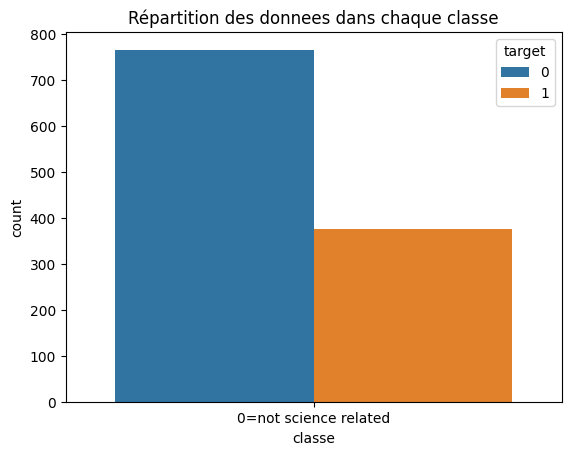

In [7]:
class_balance_plot(data, class_map)

### Over / Undersampling

Duplication ou suppression de certain tweets afin d'équilibrer les données dans chaque classes

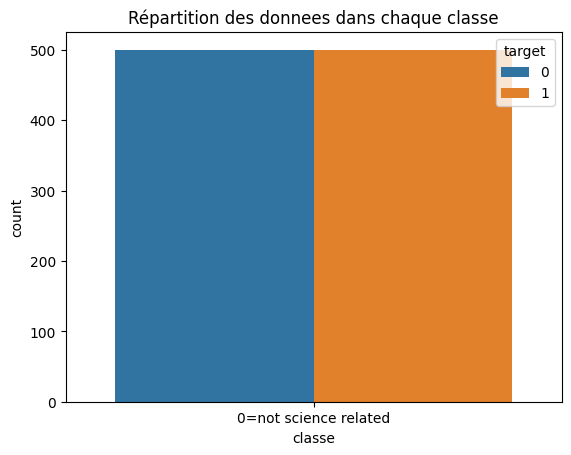

In [8]:
# Use over_under_sample to balance classes here
resampled = data.copy()

resampled = over_under_sample(0, 0, 500, resampled)
resampled = over_under_sample(0, 1, 500, resampled)

class_balance_plot(resampled, class_map)

### Appliquer les modification ci dessous

In [9]:
data = resampled

## C. Sauvegarde du jeu de données

In [10]:
data.to_csv("data.csv", index=False)

# 2. Prétraitement du texte

In [11]:
data = pd.read_csv("data.csv")
data['target'] = data['target'].apply(ast.literal_eval)

## A. Suppression des contractions

Par exemple I'm devient I am

In [12]:
data["text"] = data.apply(lambda x: contractions.fix(x["text"]), axis=1)

## B. Encodage des entitées

Les entitées sont encodées par des identifiants directement dans les tweets pour faciliter la tokenization:
- @someone : mention someone
- #something : hashtag something
- http:/t.co/eehfd : url
- 🏀 : emoticon
- 42 : number
- 50$ : number money
- 30% : number percent
- some_some : some some

In [13]:
# Choose here what to do with entity ("none", "replace" or "delete") and run to apply
settings = {
    "tags": "replace",
    "mention": "replace",
    "url": "replace",
    "emoji": "replace",
    "numbers": "replace",
    "underscore": "remove"
}

data["text"] = data.apply(lambda x: encode(x["text"], settings), axis=1)

## C. Suppression des stop / close words et de la ponctuation

Les close words sont des mots qui ne tiennent pas beaucoup de sens dans une phrase : conjonction, déterminant, pronom...

On peut conserver les auxiliaires car certain pourrait avoir du sens dans un contexte scientific : "coffe MAY be good for health"

In [14]:
to_keep = [
    "ADJ",   # adjective
    "ADV",   # adverb
    "AUX",   # auxiliary
    "INTJ",  # interjection
    "NOUN",  # noun
    "PROPN", # proper noun
    "VERB",  # verb
]

data["text"] = data.apply(lambda x: filter_words(x["text"], to_keep), axis=1)

## D. Lemmatization et mise en minuscule

Chaque mot est réduit à sa racine pour regrouper les mots au sens similaire

In [15]:
data["text"] = data.apply(lambda x: " ".join([token.lemma_.lower() for token in nlp(x["text"])]), axis=1)

## E. Filtre additionel pour les exception

On peut vouloir filtrer des termes précis en plus.

In [16]:
to_remove = [
]

data["text"] = data["text"].apply(lambda x: " ".join([w for w in x.split(" ") if w not in to_remove]))

## F. Sauvegarde des données pré-traités

In [17]:
data["text"] = data.apply(lambda x: x["text"].rstrip(), axis=1)
data = data[data['text'] != ""] # Au cas ou certain tweets n'aurait plus aucun mots
data.to_csv("preprocessed.csv", index=False)

# 3. Vectorisation

Le texte est transformé en vecteur de nombres pour être traité par le model. Pour chaque vectorization on évalue un indice de séparation des classes appelé silouhette score : plus il est proche de 1 mieux les données sont séparés. On visualise aussi les données en 3d et 2d grace a une réduction de dimension (PCA).

In [18]:
data = pd.read_csv("preprocessed.csv")
data['target'] = data['target'].apply(ast.literal_eval)

## A. Vectorization Count

Compte le nombre d'occurence de chaque token dans chaque tweet. On peut changer le ngram pour comter des tuples de tokens successifs.

Average Silhouette Score for Count Vectorizer: 0.0029412158829176596


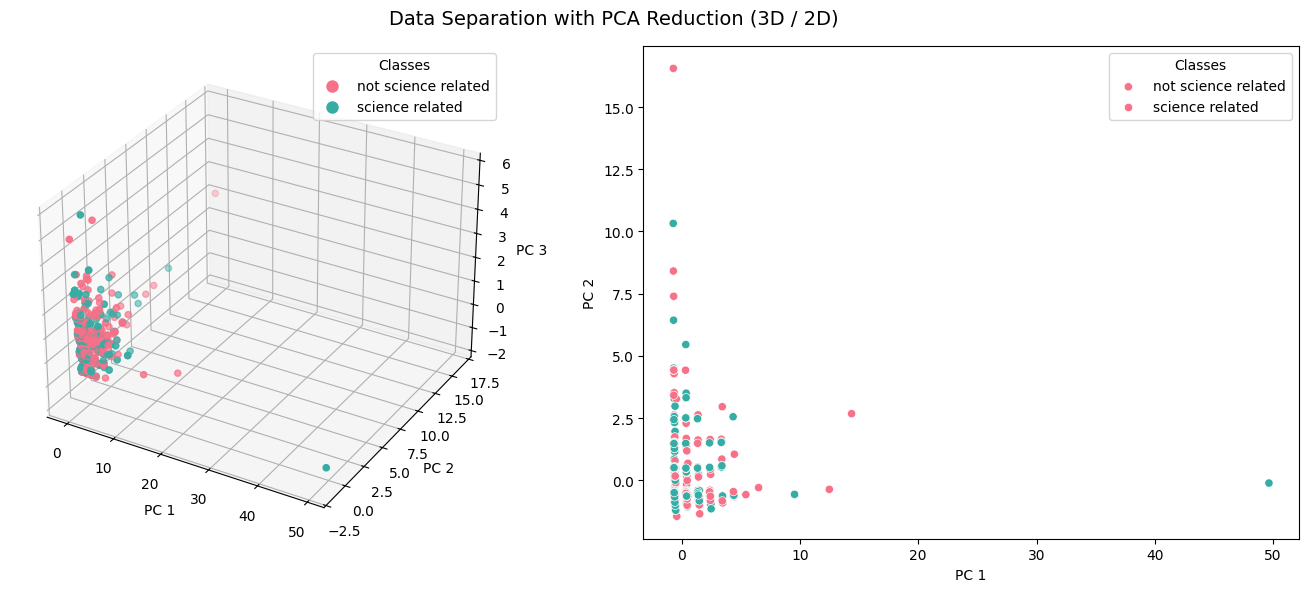

In [19]:
cv = CountVectorizer(
    ngram_range=(1,1),
    min_df=1,
    max_df=1.0,
    strip_accents='ascii'
)
cv_data = vectorize_df(data, cv)
print(f"Average Silhouette Score for Count Vectorizer: {get_silouhette(cv_data)}")
display_separation(cv_data, class_map)

## B. Vectorization TF-IDF

Approche similaire au count vectorizer, plutot que de compter chaque token, on assigne un poid qui dépend du nombre d'occurence dans le tweet, ainsi que du nombre d'occurence dans l'ensemble des tweets. Ici aussi on peut utiliser le ngrams.

Average Silhouette Score for TF-IDF: 0.001983743370751696


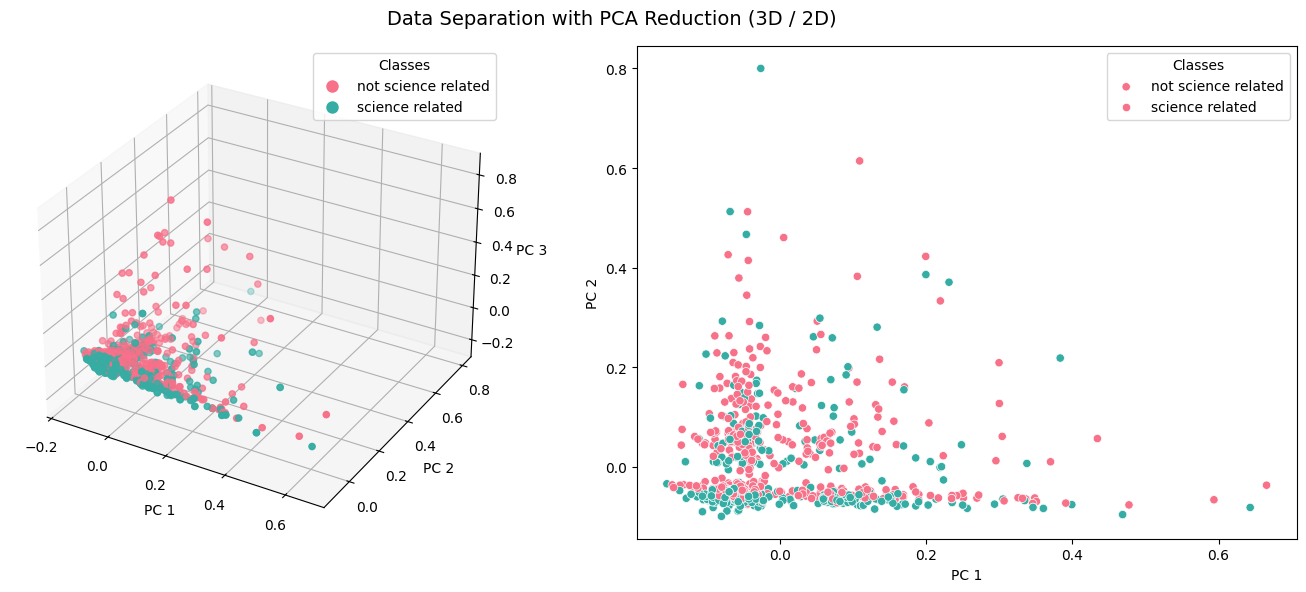

In [20]:
tf = TfidfVectorizer(
    ngram_range=(1,1),
    min_df=1,
    max_df=1.0,
    strip_accents='ascii'
)
tf_data = vectorize_df(data, tf)
print(f"Average Silhouette Score for TF-IDF: {get_silouhette(tf_data)}")
display_separation(tf_data, class_map)

## C. Sauvegarde des données vectorisés

On peut se baser sur le silouhette score ou la représentation graphique pour choisir la vectorisation à conserver ci dessous.

In [21]:
data = tf_data
data.to_csv("vectorized.csv", index=False)

# 4. Feature Selection et Filtrage des Outliers

Il faut filtrer les features pour réduire le bruit et améliorer la précision du model.

In [22]:
data = pd.read_csv("vectorized.csv")
data['target'] = data['target'].apply(ast.literal_eval)

## A. Filtrage par variance

On peut commencer par supprimer les colonnes ou une seul valeur est différente des autres. Par exemple, si pour un token donné, la valeur est la même pour toutes les données, cela n'est pas informatif pour la classification. Pour cela on affiche la distribution des variances de toutes les features, puis on choisit un seuil en dessous duquel on supprime la feature. 

2406 / 4711 features supprimées par variance.


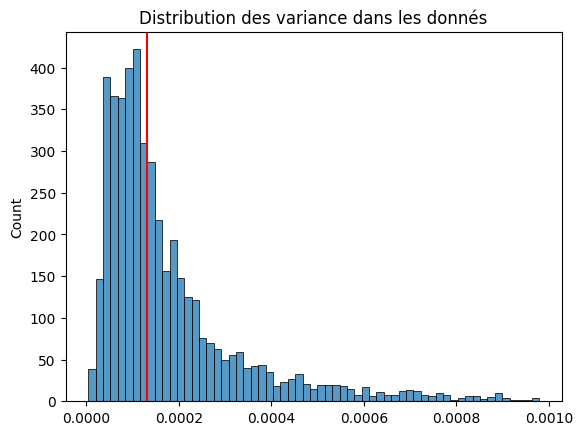

In [23]:
ignore_above = 0.001 # limit the max variance to ignore outlier and get better display
min_var = 0.00013

variance_values = data.drop(columns=["target"]).var()
to_ignore = variance_values[variance_values > ignore_above].index.tolist()

var_selected = data.drop(columns = variance_values[variance_values < min_var].index)
print(f"{len(data.columns) - len(var_selected.columns)} / {len(data.columns)} features supprimées par variance.")

ax = sns.histplot(data=data.drop(columns=["target"] + to_ignore).var().values)
plt.axvline(x=min_var, color="red")
ax.set_title("Distribution des variance dans les donnés")
plt.show()

### Appliquer le filtre

In [24]:
data = var_selected

## B. Filtrage des features très corrélés

Si deux features sont très corrélés, elle donnent le même signal et donc il n'est pas intéressant de conserver les deux.

In [25]:
merge_above = 0.99

corr_matrix = data.drop(columns=["target"]).corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > merge_above)]

corr_selected = data.drop(columns=to_drop)
print(f"{len(data.columns) - len(corr_selected.columns)} / {len(data.columns)} features supprimées par corrélations.")

636 / 2305 features supprimées par corrélations.


### Appliquer le filtre

In [26]:
data = corr_selected

## C. Filtrage des Outliers

On peut filtrer les données abérantes, soit en se basant sur la vizualization en 3d pour repérer les coordonnées des outliers, soit en exploitant le zscore pour les chercher automatiquement.

0 / 999 outliers supprimées par zscore.


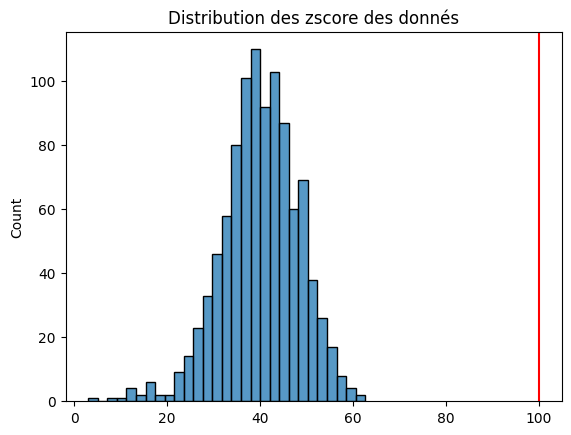

In [27]:
zscores = multivariate_zscore(data)

max_z = 100

z_selected = data[zscores < max_z]
print(f"{len(data) - len(z_selected)} / {len(data)} outliers supprimées par zscore.")

ax = sns.histplot(data=zscores)
plt.axvline(x=max_z, color="red")
ax.set_title("Distribution des zscore des donnés")
plt.show()

### Appliquer le filtre

In [28]:
data = z_selected

## D. Sauvegarde des données filtrés

In [29]:
data.to_csv("filtered.csv", index=False)

# 5. Normalisation et Projection

In [30]:
data = pd.read_csv("filtered.csv")
data['target'] = data['target'].apply(ast.literal_eval)

## A. Normalisation

On peut normaliser les données pour que toutes les features aient un poid équivalent. Cela peut être effectué avec différentes méthodes par exemple MinMaxScaler, StandardScaler ou RobustScaler. 

Ici on teste toutes les combinaisons de vectorisation + normalisation pour trouver celle qui à le meilleur silouhette score.

In [31]:
scalers = {
    "min_max": MinMaxScaler(),
    "std": StandardScaler(),
    "robust": RobustScaler(),
}

scale_results = get_scaling_sum(data, scalers)
scale_results

,Scaling,Silouhette
0,min_max,0.003384
1,none,0.002935
2,robust,0.002445
3,std,0.001289


### On choisit une normalisation

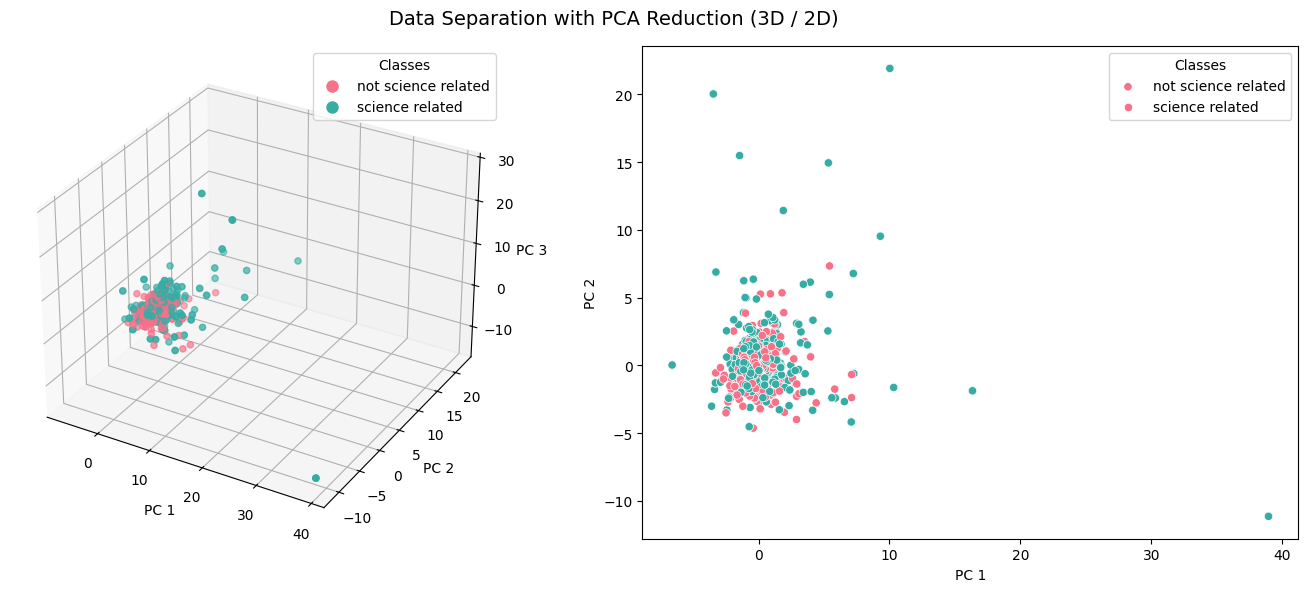

In [32]:
data = normalize_df(data, scalers["std"])
display_separation(data, class_map)

## E. Sauvegarde des données normalisé / projetés

D'après le tableau précédent on choisit une vectorisation et une normalisation pertinente pour enregistrer les données vectorisés

In [33]:
data.to_csv("normalized.csv", index=False)

# 5. Choix du modèle

On doit tester un panel de modèl pour voir lesquels sont les plus pertinents. On test plusieurs modèles et on évalue leur accuracy sur une cross validation : pour évaluer de la robustesse d'un modèle on se base surtout sur l'accuracy la plus faible.

In [34]:
data = pd.read_csv("normalized.csv")
data['target'] = data['target'].apply(ast.literal_eval)

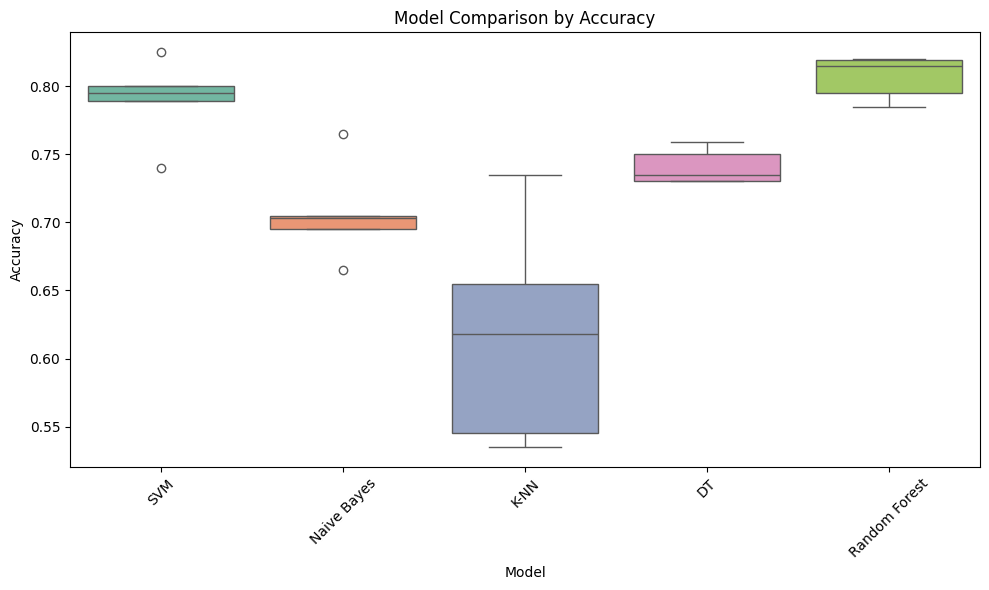

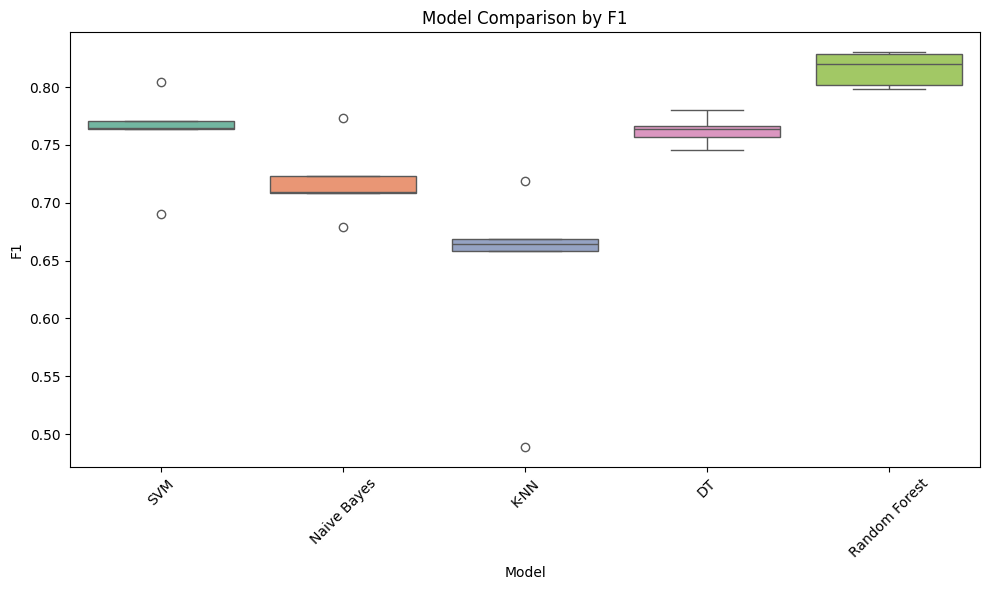

In [35]:
panel = {
    'SVM': SVC(random_state=rs),
    'Naive Bayes': GaussianNB(),
    'K-NN': KNeighborsClassifier(),
    'DT': DecisionTreeClassifier(random_state=rs),
    'Random Forest': RandomForestClassifier(random_state=rs)
}

results = evaluate_by_models(data, panel, 5, rs)
plot_model_comparison(results, "accuracy")
plot_model_comparison(results, "f1")

# 6. Recherche d'hyperparamètres

Chaque model à des paramètres et hyperparamètres qui peuvent être altérer pour améliorer l'entrainement. Le meilleur moyen d'obtenir la combinaison de paramètres optimal est de toutes les tester.

In [36]:
data = pd.read_csv("normalized.csv")
data['target'] = data['target'].apply(ast.literal_eval)

## A. Recherche aléatoire

On peut utiliser RandomSearchCv pour tester des combinaisons aléatoires, nous permettant de réduire l'espace de recherche pour la suite

In [37]:
model = RandomForestClassifier(random_state=rs)
params_rnd = {
    'n_estimators': list(range(20, 201, 30)),  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],    # Maximum depth of the tree
    'min_samples_split': list(range(2, 21, 2)),  # Minimum number of samples required to split an internal node
    'min_samples_leaf': list(range(1, 11)),   # Minimum number of samples required to be at a leaf node
    'criterion': ['gini', 'entropy', 'log_loss'],     # Function to measure the quality of a split
    'bootstrap': [True, False],           # Whether bootstrap samples are used when building trees
    'class_weight': [None, 'balanced', 'balanced_subsample'],  # Class weights to handle class imbalance
    'max_features': ['sqrt', 'log2']
}
rnd_results = hyperparam_rnd_search(data, model, params_rnd, 50, 'accuracy', 5, rs)
print(f"Best parameters : {rnd_results.best_params_}")
print(f"With score : {rnd_results.best_score_}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters : {'n_estimators': 200, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None, 'criterion': 'gini', 'class_weight': 'balanced', 'bootstrap': False}
With score : 0.8298341708542714


## B. Recherche exhaustive

On test toutes les combinaisons pour un ensemble de paramètres (C'est trop long si on veux tester tous les paramètres)

In [38]:
#model = RandomForestClassifier(random_state=rs, max_features='sqrt', class_weight="balanced", criterion="entropy")
#params = {
#    'n_estimators': [80, 200],     # Number of trees
#    'max_depth': [None],    # Maximum depth of trees
#    'min_samples_split': [8, 20],    # Minimum samples to split a node
#    'min_samples_leaf': [1],      # Minimum samples required at a leaf node
#}
#metric = 'accuracy'
#
#hs_results = hyperparam_search(data, model, params, metric, 5, rs)
#print(f"Best parameters : {hs_results.best_params_}")
#print(f"With score : {hs_results.best_score_}")

## C. Évaluation détaillé

On réalise une cross validation en analysant les metriques suivantes pour chaque classe : precision, recall, f1, accuracy, matrice de confusion

Classification Report (Overall):
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       500
           1       0.85      0.81      0.83       499

    accuracy                           0.83       999
   macro avg       0.83      0.83      0.83       999
weighted avg       0.83      0.83      0.83       999

Accuracy for each fold: [0.83       0.86       0.82       0.805      0.83417085]
Mean Accuracy: 0.8298, Std: 0.0181

Confusion Matrices : 


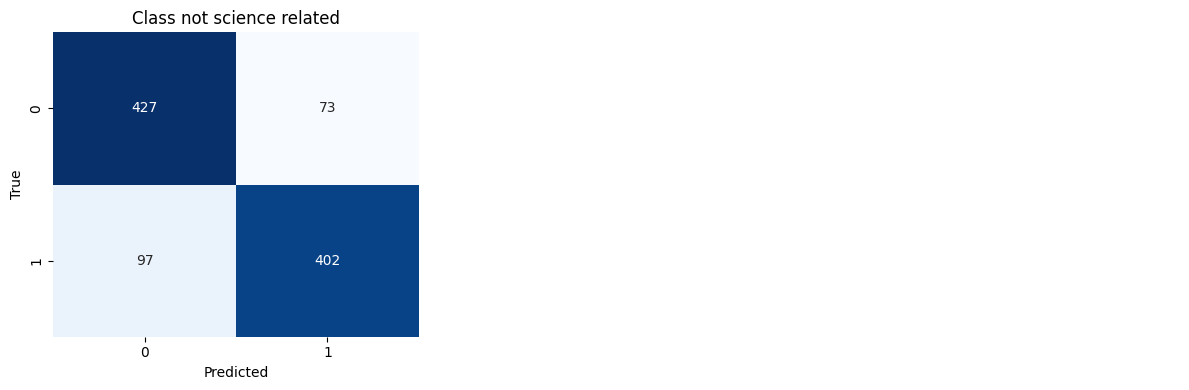

In [39]:
X = data.drop(columns=["target"]).values
y = data["target"].apply(lambda x: x[0]).values
model = rnd_results.best_estimator_
results = evaluate_model(data, model, 5, rs)

print("Classification Report (Overall):")
print(results["report"])

print(f"Accuracy for each fold: {results["acc"]}")
print(f"Mean Accuracy: {np.mean(results["acc"]):.4f}, Std: {np.std(results["acc"]):.4f}")

print(f"\nConfusion Matrices : ")
display_confusions(results["cm"], class_map)

In [40]:
import json
print(json.dumps({
    "acc": list(results["acc"].flatten()),
    "prec": list(results["precision"].flatten()),
    "rec": list(results["recall"].flatten()),
    "f1": list(results["f1"].flatten())
}, indent=4))

{
    "acc": [
        0.83,
        0.86,
        0.82,
        0.805,
        0.8341708542713567
    ],
    "prec": [
        0.8301320528211285,
        0.8671970624235006,
        0.82,
        0.8087357019941289,
        0.8344451182534869
    ],
    "rec": [
        0.83,
        0.8600000000000001,
        0.82,
        0.8049999999999999,
        0.8342424242424242
    ],
    "f1": [
        0.8299829982998299,
        0.8593106220480353,
        0.82,
        0.8044083352140223,
        0.8341541025835291
    ]
}
